**Authors:** Patricia Domínguez, Chenxi Lu, Angelina Sheremet, and Erik Zinn

# Introduction

## Motivation and introduction to the dataset

In this study, we aim to understand the determinants of crime and present potential policy suggestions that may mitigate crime at the local government level in North Carolina. To do this, we based our analysis on cross-sectional county-level data on crime in North Carolina, a subset of data from a study called “Estimating the Economic Model of Crime with Panel Data,” published by researchers Cornwell and Trumball. The data available for each county was collected in 1987. Although a cross-sectional study may help us understand the conditions at a certain point in time, this sort of data is limiting because this time period may not be representative of North Carolina most of the time. Perhaps there was a policy change in the United States or North Carolina around this time that drastically increased or decreased crime that we have no way to measure because we only have one year of data. One example of this could be the legalization of abortion that occured within the states in the early 1970’s, which was shown to have a drastic effect on crime rate in the following years. However, although we cannot measure significant changes over time, we will use this data to interpret the state of North Carolina in 1987, and all recommendations that we give will be conditional on the fact that we do not have the full picture of the state over the years. A deeper discussion of omitted variable bias can be found in the discussion section below.

Thus, given the data available, we will focus on following sets of variables:
- Different measures of punishment for offenses, which may play a role in deterring crime
- Inherent county attributes that may not be changed (e.g. population density, demographics), but may inform strategies for crime reduction
- Attributes that are directly controlled by local governments (e.g. tax revenue, police per capita), which are levers that may be adjusted to reduce crime
- Weekly wage information across various industries, which may indicate if there exist economic stressors that may motivate crime

Specifically, we want to determine what is the effect of probability of punishment on crime rate. We would anticipate that a higher probability of punishment would deter people from committing a crime. We use the variable `crmrte` (crimes committed per person) to measure the crime rate. A higher number of crimes committed per person represents a higher crime rate. To understand the role of punishment as a crime deterrent we choose as a key variable the probability of punishment `prbarr` (probability of arrest, or ratio of arrests to known offenses). We will also consider `prbconv` (probability of conviction conditional on the arrests) for similar reasons. On the other hand, `prbpris` (probability of prison sentence conditional conviction) and `avgsen` (average days of sentence conditional on imprisonment) would not operationalize the probability of punishment in this context, because prison sentences are usually for more severe crimes that happen relatively infrequently. While the fear of imprisonment could deter people from committing serious crimes, it may hardly have any effect on deterring people from committing mild crimes.

A key covariate for understanding crime in North Carolina was population density measured by `density` which measures the people per square mile. Population density is a proxy measure of societal interactions, and with more interactions one might expect to observe more crime.

## Exploratory data analysis

Before we could begin our analysis, we performed a full data cleaning and exploratory data analysis to not only identify any data intricacies we needed to be aware of, but also look into variables of interest. We initially removed 10 rows of data that were made up of NA values.

In [1]:
# Loading necessary package dependencies
suppressMessages(library(plyr))
suppressMessages(library(tidyverse))
suppressMessages(library(car))
suppressMessages(library(lmtest))
suppressMessages(library(sandwich))
suppressMessages(library(stargazer))
suppressMessages(library(ggplot2))
suppressMessages(library(reshape2))
suppressMessages(library(Hmisc))
suppressMessages(library(psych))

# Loading data and viewing 
setwd("~/Documents/mids/w203-stats/lab_3")
crime_v2 <- read.csv("crime_v2.csv")

# Remove NA rows
crime_v2 <- crime_v2 %>% drop_na()

Then we transformed the variable `prbconv` from factor to numeric. We removed the observations with probability variables (e.g. `prbarr` and `prbconv`) having values beyond $[0, 1]$. All 25 variables given looked relatively relevant to our analysis except for year (which was the same for each row because this was a cross-sectional study), and county, which would not give us any relevant information. In the end, we were left with 81 observations and 23 variables for our analysis.

In [2]:
# prbarr, prbconv, prbpris, pctmin80, pctymle: probabilities in [0, 1]
crime_v2$pctmin80 <- crime_v2$pctmin80 * 0.01
crime_v2[, grep("prb|pct", colnames(crime_v2))] <- 
  apply(crime_v2[, grep("prb|pct", colnames(crime_v2))], 2, 
        function(x) ifelse(x < 0 | x > 1, NA, x))
crime_v2 <- data.frame(apply(crime_v2, 2, as.numeric))
# Dropping NAs produced
crime_v2 <- crime_v2 %>% drop_na()

We also transformed all wage variables to their natural logs in order to better understand proportional differences across these wages in different counties rather than the absolute differences. Similarly, we convert the original `polpc` and `taxpc` into the natural log form. The `polpc` variable varies from 0.0008 to 0.004, meaning that, on average, the county with the lowest police per capita has 0.8 police officers for every 1,000 residents, while the highest has four. Adding one police officer per 1,000 people would have different impacts for counties with different initial police per capita. We use the log form of `polpc` so that we can interpret the coefficient such that doubling the police force is associated with x percentage points change in crime rate. The `taxpc` variable (tax revenue per capita) value varies from \\$25.7 to \\$119.8, with the mean of \\$38 and median of \\$34.5; therefore, adding \\$1 tax revenue per capita would have a varied impact for counties with different levels of tax revenue.

In [3]:
# Applying the natural logarithm for wage data, polpc, and taxpc
numeric_cols <- c(colnames(crime_v2[, 15:23]), 'polpc', 'taxpc')
log_cols <- paste0("log_", numeric_cols)
for(i in 1:length(log_cols)) {
    crime_v2[, log_cols[i]] <- log(crime_v2[, numeric_cols[i]])
}

We begin by taking a look at our dependent variable, crime rate. We begin by plotting a histogram of crime rate, which clearly shows us that the data is skewed right, with a long tail. This means that most counties have a lower crime rate, with an average crime rate of 3.5%. The lowest crime rate in a county is 1%, and the highest is 9.9%, with the median similar to the mean at 3%. 

[1] "Summary Statistics of crimes committed per person"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01062 0.02337 0.03043 0.03536 0.04374 0.09897 

[1] "The crimes committed per hundred people varies from 1.1 to 9.9"
[1] "The median crime rate is about 3 per hundred people, mean is about 3.5."


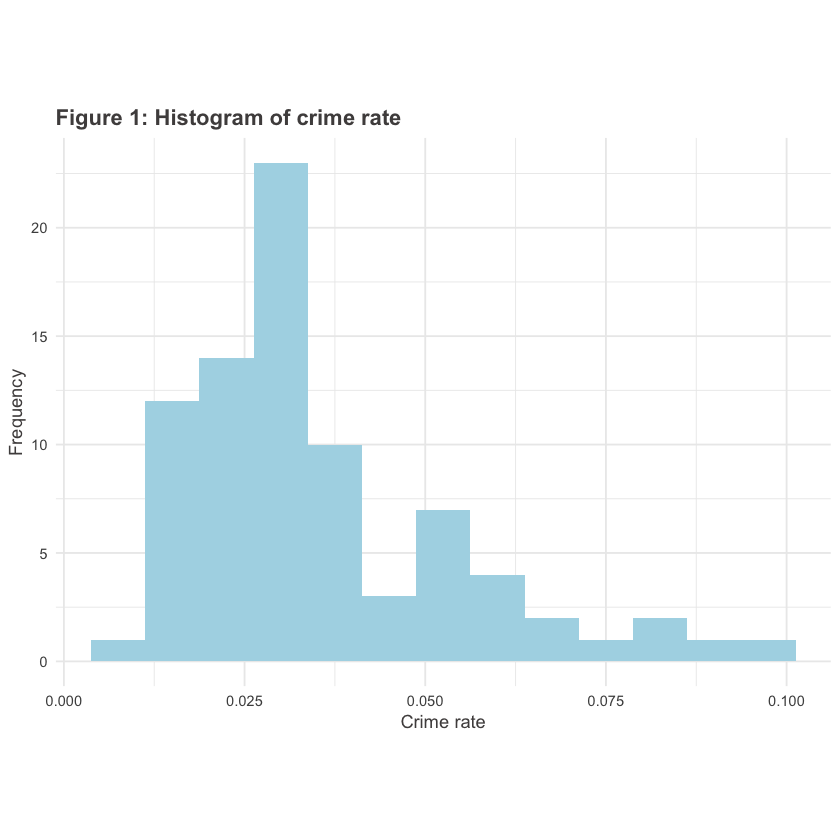

In [4]:
# Plotting a histogram for crime rate
print("Summary Statistics of crimes committed per person")
summary(crime_v2$crmrte)
print("The crimes committed per hundred people varies from 1.1 to 9.9")
print("The median crime rate is about 3 per hundred people, mean is about 3.5.")

ggplot(crime_v2, aes(x=crmrte)) + geom_histogram(binwidth=0.0075, fill='lightblue') +
    ggtitle('Figure 1: Histogram of crime rate') + xlab('Crime rate') + ylab('Frequency') +
    theme_minimal() + coord_fixed(0.003) +
    theme(text=element_text(color="#4f4c4c"),
          plot.title=element_text(face="bold"))

Next, we take a look at the distributions of all of our numeric variables. We can see that density, mix, pctymle, polpc, taxpc, and wtrd are also right skewed with long tails. The percentage of  minority populations appear to be multi-modal, while all other variables appear mostly normal.  

Because we knew we would be taking the log of certain variables in our dataset, we plotted histograms of the distributions of these variables after the natural log transformation, as shown below:

No id variables; using all as measure variables
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


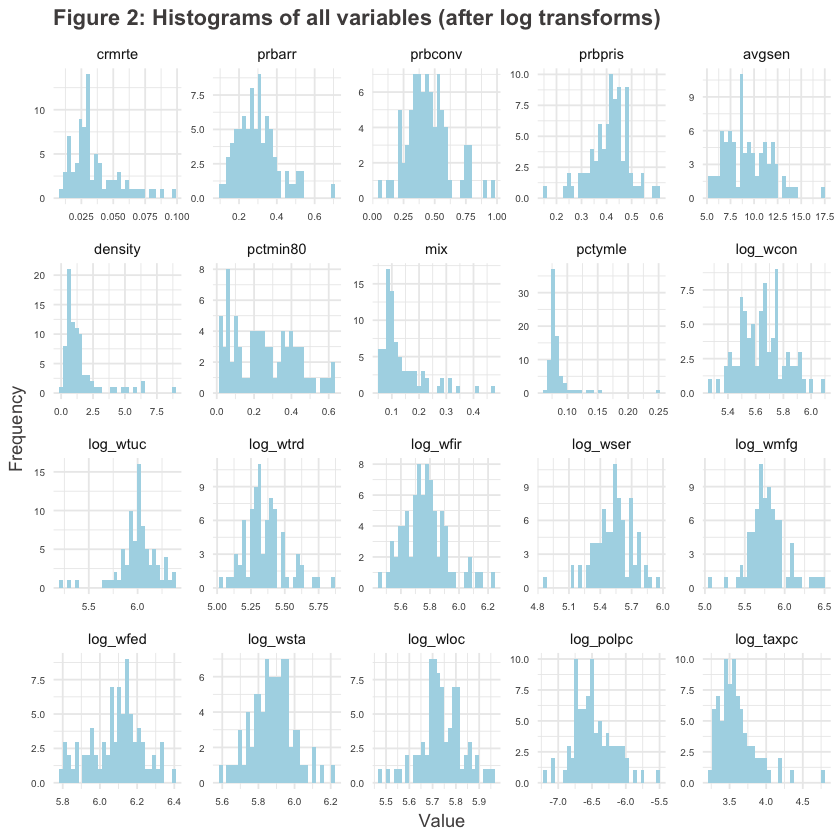

In [5]:
log_hist <- crime_v2 %>% select(-c(county, year, west, central, urban))
log_hist <- log_hist[, !colnames(log_hist) %in% numeric_cols]
log_hist <- melt(log_hist)
ggplot(log_hist, aes(x=value)) + geom_histogram(fill='lightblue') + 
    facet_wrap(~variable, scales="free") + 
    ggtitle('Figure 2: Histograms of all variables (after log transforms)') + 
    xlab('Value') + ylab('Frequency') + theme_minimal() +
    theme(text=element_text(color="#4f4c4c"),
          plot.title=element_text(face="bold"),
          axis.text=element_text(size=6))

We also took a look at some of our categorical and binomial variables. We found that on average, 23% of people in the relevant counties live in the west, 40% live in the central, and 37% live in the east. There was one county that identified as both west and central. This could be due to a data issue or perhaps geographic locational boundaries are not well defined for certain counties. On average, 10% of the population live in urban areas. The average crime rates in western and central counties are 0.024 and 0.039, respectively.

Lastly, we were interested in any existing correlations among our variables. Since we knew crime rate would be our dependent variable, we were specifically interested in relationships that involve crime rate. We see that `density` and `urban`, which are highly related variables, are the most correlated with `crmrte`; `polpc` and `prbarr` (which are also inevitably intertwined) are the next highest, followed by `taxpc`, which likely increases with the density of a county. All other variables have correlation magnitudes $< 0.45$.

In [6]:
# Creating dataset with final log transforms
final_crime_data <- crime_v2[, !colnames(crime_v2) %in% numeric_cols]

# All correlations with crmrte
crmrte_corr <- as.data.frame(cor(final_crime_data[, 4:25], final_crime_data$crmrte))
colnames(crmrte_corr) <- c('correlation')
crmrte_corr$variable <- rownames(crmrte_corr)
crmrte_corr$abs_corr <- abs(crmrte_corr$correlation)
crmrte_corr <- crmrte_corr[, c('variable', 'correlation', 'abs_corr')]

# Output table
print("Table 1: Independent variable correlations with `crmrte`")
crmrte_corr %>% arrange(desc(abs_corr))

[1] "Table 1: Independent variable correlations with `crmrte`"


variable,correlation,abs_corr
density,0.72431412,0.72431412
urban,0.62080512,0.62080512
log_polpc,0.59661380,0.59661380
prbarr,-0.50614586,0.50614586
log_taxpc,0.44736727,0.44736727
log_wfed,0.44230473,0.44230473
log_wmfg,0.42095639,0.42095639
log_wloc,0.41866492,0.41866492
log_wtrd,0.36361351,0.36361351
log_wcon,0.34788703,0.34788703


As a sanity check, we visualize the relationships between variables with correlation values greater than 0.4:

[1] "Figure 3: Linear relationships between independent variables and `crmrte`"


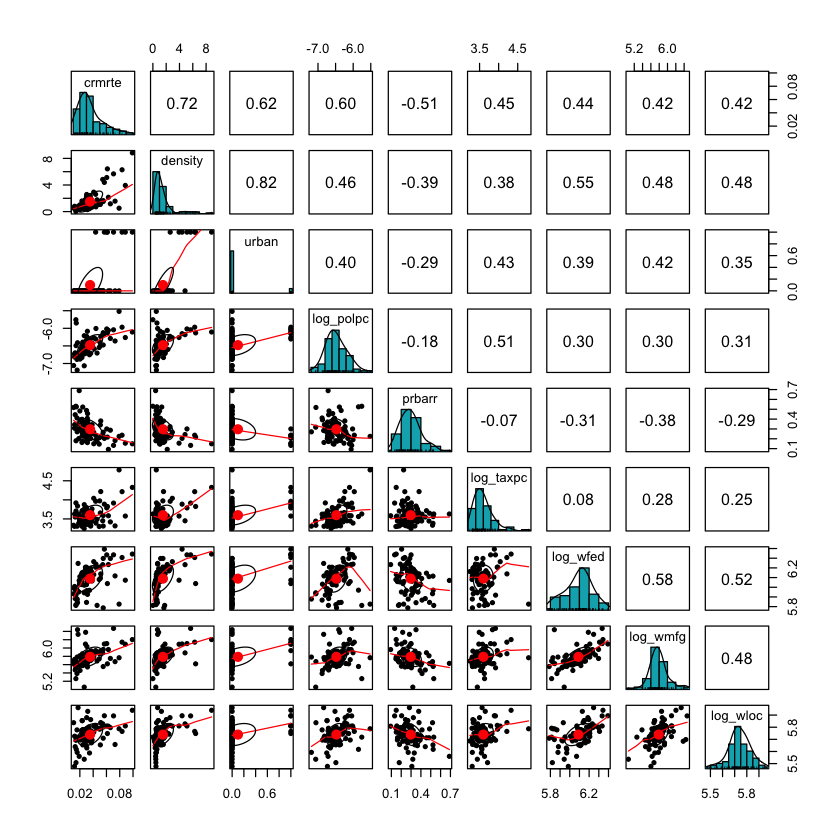

In [7]:
# Looking at relationships between crmrte and highly correlated variables 
print("Figure 3: Linear relationships between independent variables and `crmrte`")
pairs.panels(final_crime_data[, c("crmrte", "density", "urban", "log_polpc", "prbarr", 
                                  "log_taxpc", "log_wfed", "log_wmfg", "log_wloc")],
             method = "pearson", # correlation method
             hist.col = "#00AFBB",
             density = TRUE,  # show density plots
             ellipses = TRUE # show correlation ellipses
            )

Going forward, we now understand which variables are most linearly correlated with crime rate. We also found the following findings may provide some guidance to our model building process:
- `urban` is relatively highly correlated with `density` ($cor(density, urban) = 0.82$)
- `west` and `central` may conflate with `urban` as well, seeing as that counties may be both urban and located in one of these regions. Because of this, adding all these variables in one model may make them individually insignificant. It would require us to conduct an F-test.

# Model Building

## A minimal approach, using only key variables

Here, we want to explore the relationship between crime rate and probability of arrest, while including the population density as a covariate. We only include the variables that we deem to be most likely to influence the overall crime rate: `prbarr` (the key independent variable) and `density` (the main control variable). The probability of arrest, `prbarr`, is computed as the ratio of arrests to offenses (not a true probability) which is a sufficient proxy for the likelihood of punishment in a given county. The number of people per square mile is measured by `density`. Population density is a proxy measure of societal interactions, and with more interactions one might expect to observe more crime. We did not transform any of the variables used.

These variables make sense from both a theoretical standpoint, as stated above, and from our initial exploratory data analysis. Both were highly correlated with crime rate (`prbarr` was correlated negatively with `crmrte` and `density` was correlated positively). We do not include other covariates here because many of them are closely aligned to `density` in that they may absorb some of its causal effect. For instance, wages are typically higher in places that have higher density, since living costs are higher. Likewise, tax revenue will likely be higher in denser areas as well. 

In [8]:
model.minimal <- lm(crmrte~prbarr+density, final_crime_data)

## Several balanced approaches

Having finished an initial exploratory data analysis as well as probed a minimal approach model, we turn to a series of plausible ideas around which actionable recommendations may possibly lead to an overall decrease in crime rate in North Carolina. For each idea, we create a corresponding model to understand what may be the implications based on this county data.

*Idea 1:* Increasing the overall probability of arrest (`prbarr`) by improving police training, designating police specializations, and overall supporting police personnel (benefits, staff, etc.) will lead to a reduced crime rate. Covariates include: `density`, `prbconv` (arrests that actually lead to conviction), `log_polpc`, demographic characteristics, location, and relevant wages.

We are ultimately aiming to understand the causal relationship between crime rate and the probability of arrest, given its high negative correlation with crime rate. Since among all CLM assumptions, we already have tools to address or go around some violations of zero-conditional means, heteroskedasticity, and non-normal error terms (for more discussions, see MLR Assumptions section below), we will focus on exogeneity here. So the following models, we will expand our minimal model by trying to address possible omitted variable bias:

- We add `prbconv` into our model as a control variable because we think omitting it will cause positive omitted variable bias (towards zero, given our belief that the true effect is negative). We believe that there is a negative correlation between the probability of arrest and the probability of conviction conditional on arrest, since the increasing arrest rate may increase the occurrence of false positives, which may lower the conviction rate. There is also a negative correlation between crime rate and the probability of conviction conditional on arrest because of the deterring effect from the possibility of getting convicted.
- We add `log_polpc` into our model as a control variable because omitting it may cause a negative omitted variable bias (away from zero). There is a positive correlation between the probability of arrest and police per capita, since more police may address more offenses, leading to an increase in arrest rate. In theory, police per capita may also decrease crime rate; however, we are also aware of a potential reverse causality problem: more police could be assigned to high crime rate counties.
- We think county demographic characteristics matter. We add both `pctmin80` (population share of minority) and `pctymle` (population share of young men) as control variables, since omitting them would result in some omitted variable bias, though the direction is debatable. For example, while we are uncertain about the correlation between crime and minority populations, we think the minority populations may be perceived as committing more crimes, which would increase their probability of arrest. 
- We think region-specific characteristics matter. So we add the geographical dummy variables “west” and “central” as control variables. Note that the baseline category omitted here (to avoid perfect multicollinearity) is east, which is not in the variable list anyway. For the same purpose, we also add the dummy variable “urban” as a control variable. These region-specific characteristics may have correlations with both `crmrte` and `prbarr`.
- Finally, we believe that a healthy labor market would be associated with a lower crime rate, so we add some log-transformed weekly wage variables. We examined summary statistics of all wage variables in different industries, and find the following three industries have the lowest average wage: (1) wholesale and retail trade (“wtrd”), (2) service industry (“wser”), and (3) construction (“wcon”). The average weekly wages are: \\$213, \\$255, and \\$288, respectively. We think these low-wage sectors are more relevant in our model than other sectors, since widespread economic insecurity may lead to higher crime rates. Low wages, combined with high living expenses in dense areas, may exacerbate this effect. We chose to only use wages of these three representative sectors to avoid potential high levels of multicollinearity among control variables (specifically, with other wage variables). We are aware, however, that there may be some multicollinearity issue even within these three variables, so we plan to conduct an F-test to see if they are jointly significant (for more discussion on this, please see Section 4).

In [9]:
model.idea1 <- lm(crmrte~prbarr+prbconv+density+log_polpc+west+central+urban+
                  pctmin80+pctymle+log_wser+log_wtrd+log_wcon, data=final_crime_data)

*Idea 2:* By using BIC to find an optimal multiple regression model, we can identify the most instrumental variables in determining what impacts crime rate. After identifying these variables, a recommendation may be made.

We based a third model on a backwards stepwise regression using the BIC (bayesian information criterion) to identify which variables predicted crime rate the best. AIC (Akaike Information Criterion) and BIC are both commonly used criteria to identify an optimal multiple regression model. AIC is derived from the frequentist approach, while BIC is defined from a bayesian approach. The biggest difference between them is the penalties given to more complicated/ larger models. We decided to use BIC because we wanted a simpler and smaller model. 

Using backwards stepwise regression, we identified nine optimal variables used to predict crime rate: percent of arrests, the natural log of police per capita, population density, percent minority, percent young male, and the natural log of three weekly wage variables: wholesale, finance/real-estate, and state employees. The adjusted $R^2$ of our final model was 83%, meaning the model explained 83% of the variance among our dependent variables. All the coefficients in this model were significant, but probability of arrest seemed by far the most significant and had the largest coefficient (more details are included in Table 3).

Our initial exploratory data analysis supports the chosen variables for similar reasons as `model.idea1`. It is the case, however, that there may exist some collinearity among the wage variables for reasons stated earlier, and between density and the wage variables as well, seeing as waves tend to be higher in dense areas where the cost of living is expensive. Additionally, it may be the case that non-white populations make up higher proportions of dense, urban areas, thereby causing some collinearity as well.

In [10]:
model.idea2 = lm(crmrte~prbarr+density+log_polpc+log_taxpc+pctmin80+pctymle+log_wtrd+
                 log_wfir+log_wsta, data=final_crime_data)

## A maximal approach

We sought to understand what the impact of `prbarr` and `density` were on `crmrte` while including as many relevant covariates as were available. We built a model using as many variables as made sense, with the exception of `prbpris`, `avgsen`, `urban`, `west`, and `central`. This model included all other variables pertaining to crime, arrest, and arrest outcomes, county attributes and demographics, and all variables pertaining to the weekly wage across various industries. Once again, we used the natural logarithms of all wage variables, `polpc`, and `taxpc` for reasons stated in Section 1.2. Initially, it is clear that `pctymle`, or percentage of young men, has the largest positive impact on crime rate, whereas `prbarr`, or probability of arrest, has the largest negative impact. Full results are displayed in Table 3.

Since this approach uses as many variables as deemed relevant, there are likely several that may be absorbing the effects that we want to understand from `prbarr`. For instance, variables like `polpc` and `mix` may influence `prbarr`. In this case, a higher `mix` implies a higher proportion of face-to-face crimes, which may inherently lead to more arrests. Again, wage variables and demographics variables that are included may be inherently associated with `density` as well.

In [11]:
model.maximal.df <- final_crime_data %>% select(-c(county, year, urban, west, central, prbpris, avgsen))
model.maximal <- lm(crmrte~., model.maximal.df)

Ultimately, we determined that `model.idea1` best encapsulated the relationships between `crmrte` and `prbarr`, as well as `crmrte` and `density`, while including relevant covariates that optimized the model’s ability to explain variance in the data. This model was also chosen because it was simple enough to isolate our key variables and informative covariates that are potential areas of focus for local governments to act on in mitigating crime rate. In Sections 3-5, we discuss the results of this model and how they lead to concrete recommendations for local/state government officials in North Carolina.

# Assessing CLM assumptions

## Linear population model

First, we evaluate the assumption that our population model is linear in parameters, i.e. can be written as:

\begin{equation}
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_k x_k + u
\end{equation}

where $u$ is an unobserved random error or disturbance term [1]. Since we haven't constrained the error term $u$, this describes any joint distribution; therefore, we can assume that this requirement is fulfilled for now.

## Random sampling

The dataset used in our analysis was based on a multi-year panel (our data only has information from 1987). There are 100 counties in North Carolina; after data cleaning, we had information for 81 counties available (initially 97). The assumption of random sampling is fulfilled here given that these counties should likely be representative of the population, and that the original study did not leave out any counties intially.

## No perfect multicollinearity

Next, we evaluate the assumption that none of our independent variables in the sample are constant, and there are no exact linear relationships among the independent variables. Here, we assess the variance inflation factors, and again find that no factor amounts to greater than 3(5 would be considered large):

In [12]:
# Note: R would have also dropped any variables that blatantly failed this requirement.
print("Table 2: Variance inflation factors for all independent variables")
as.data.frame(vif(model.idea1))

[1] "Table 2: Variance inflation factors for all independent variables"


,vif(model.idea1)
prbarr,1.494110
prbconv,1.531661
density,4.864314
log_polpc,1.687265
west,2.854954
central,1.987686
urban,3.431958
pctmin80,2.601796
pctymle,1.237142
log_wser,2.076287


## Zero-conditional mean

This assumption requires that the error $u$ has an expected value of zero given any of the independent variables [1], i.e.

\begin{equation}
E(u \: | \: x_1, x_2, ..., x_k) = 0
\end{equation}

To assess that the assumption holds for our model, we examine a plot of residuals versus fitted values. We find that while our fitted line lies quite close to zero, at lower values, we find that the line skews upward. This may be due to the low number of data points in this region. We are able to relax the zero-conditional mean requirement because we have a sample size of 81, much bigger than 30. Given this, we can examine the exogeneity assumption instead. If there were no omitted variables, our model would meet this requirement. But we think our model is not perfect and there must be some omitted variables. So the exogeneity assumptions could not be perfectly met.

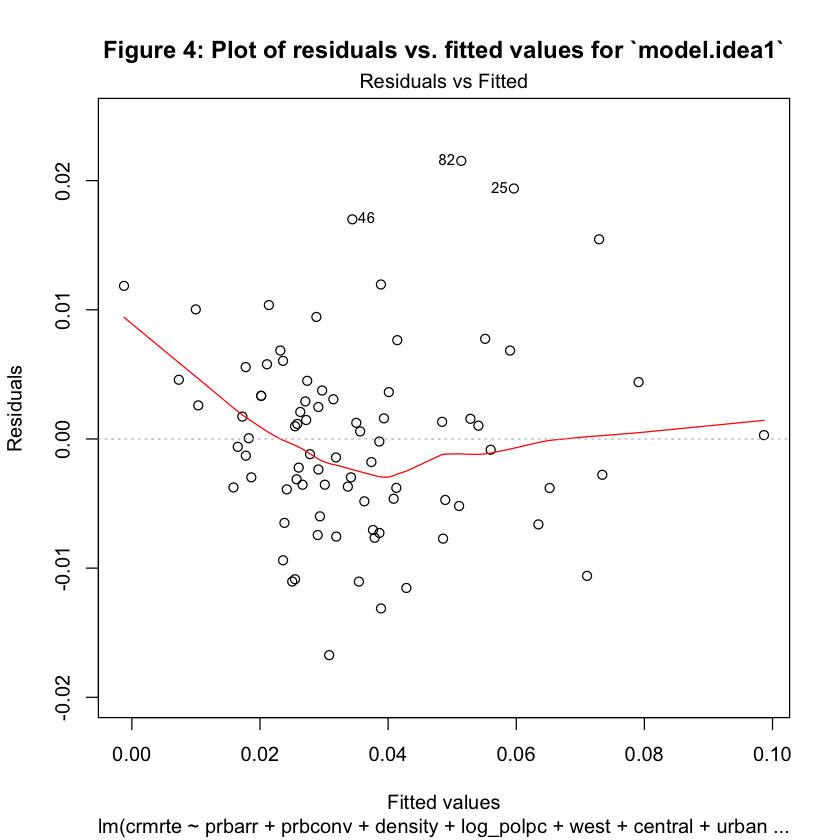

In [13]:
plot(model.idea1, which=1, main="Figure 4: Plot of residuals vs. fitted values for `model.idea1`")

## Homoskedasticity

Requiring homoskedasticity for a model means that the overall error $u$ has the same variance given any of the independent variables [1], i.e.

\begin{equation}
Var(u \: | \: x_1, x_2, ..., x_k) = \sigma^2
\end{equation}

To assess homoskedasticity, we again reference the residuals v. fitted plot (Figure 4) to see whether the spread of data points is a flat band centered around zero. While the majority of the points lie within an even spread, there are a few at higher and lower fitted values that lie outside of what would be considered a flat band. Looking at the scale-location plot in Figure 5, we see a similar distribution, which would indicate some level of heteroskedasticity.

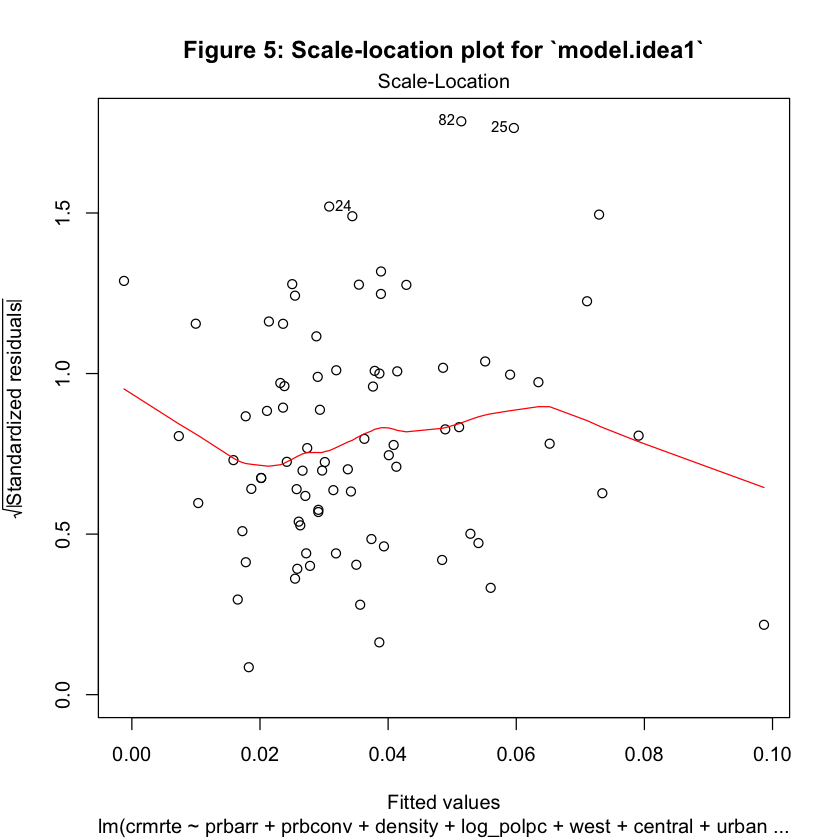

In [14]:
plot(model.idea1, which=3, main="Figure 5: Scale-location plot for `model.idea1`")

As a sanity check, we perform a studentized Breusch-Pagan test to assess the null hypothesis that our model is homoskedastic, and find that we reject the null, meaning that our model is likely heteroskedastic. In order to address this, we use the robust standard errors so that our tests are more conservative when assessing our model outcomes.

In [15]:
bptest(model.idea1)

# Returning robust standard errors:
se.model.minimal = sqrt(diag(vcovHC(model.minimal)))
se.model.idea1 = sqrt(diag(vcovHC(model.idea1)))
se.model.idea2 = sqrt(diag(vcovHC(model.idea2)))
se.model.maximal = sqrt(diag(vcovHC(model.maximal)))


	studentized Breusch-Pagan test

data:  model.idea1
BP = 23.486, df = 12, p-value = 0.02387


Here, we also take the opportunity to probe if there are any outlier data points that have high influence over our model. We find that a few points may be outliers, but do not exceed a Cook's distance of one. Similarly, point 59 exerts a high amount of influence over the model. Taking a look at this county, we find that it has the highest proportion of young males of any other county by ten percentage points.

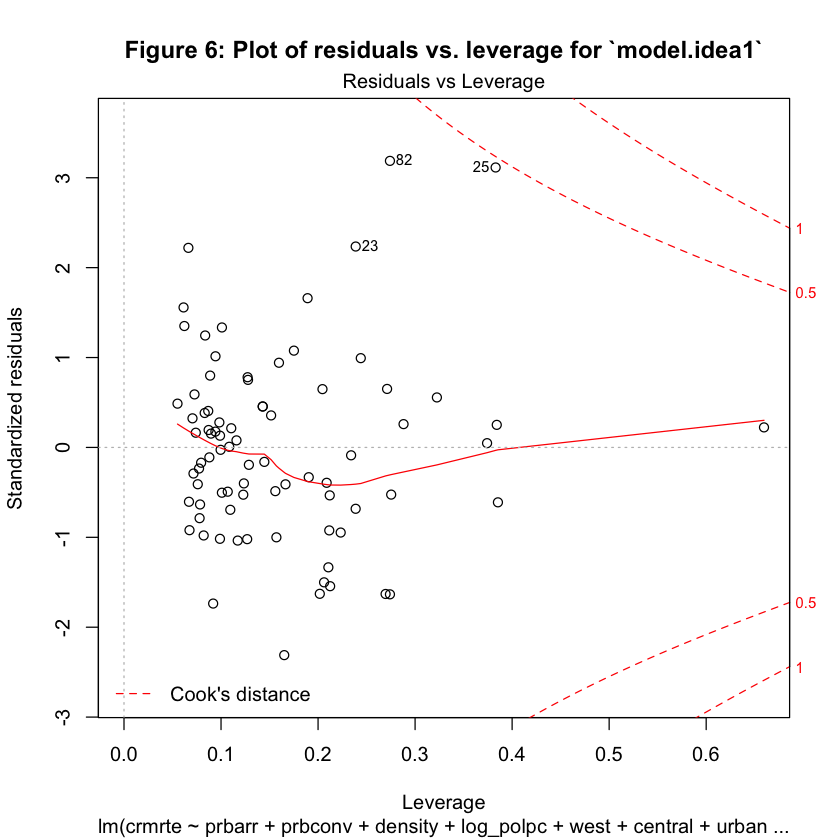

In [16]:
# Used to find which point had highest leverage:
# hatvalues(model.idea1)

plot(model.idea1, which=5, main="Figure 6: Plot of residuals vs. leverage for `model.idea1`")

## Normality of errors

The final assumption we assess here is that of normality of errors, meaning that the population error $u$ is independent of the independent variables and $u \sim N(0, \sigma^2)$ [1]. We initially look directly at a histogram of our residuals and find that they look to follow a distribution $N(0, \sigma^2)$ (see Figure i.4 in the appendix). Similarly, we look at a Q-Q plot to understand this distribution at the lower and upper tails, and come to the same conclusion. The Q-Q plot does show that counties at higher values are slightly skewed, but our sample size is large, so we can rely on the Central Limit Theorem here.

A Shapiro-Wilk test is implemented as a sanity check, with a null hypothesis that the residuals are normally distributed; here, we find we cannot reject the null.


	Shapiro-Wilk normality test

data:  model.idea1$residuals
W = 0.9783, p-value = 0.1852


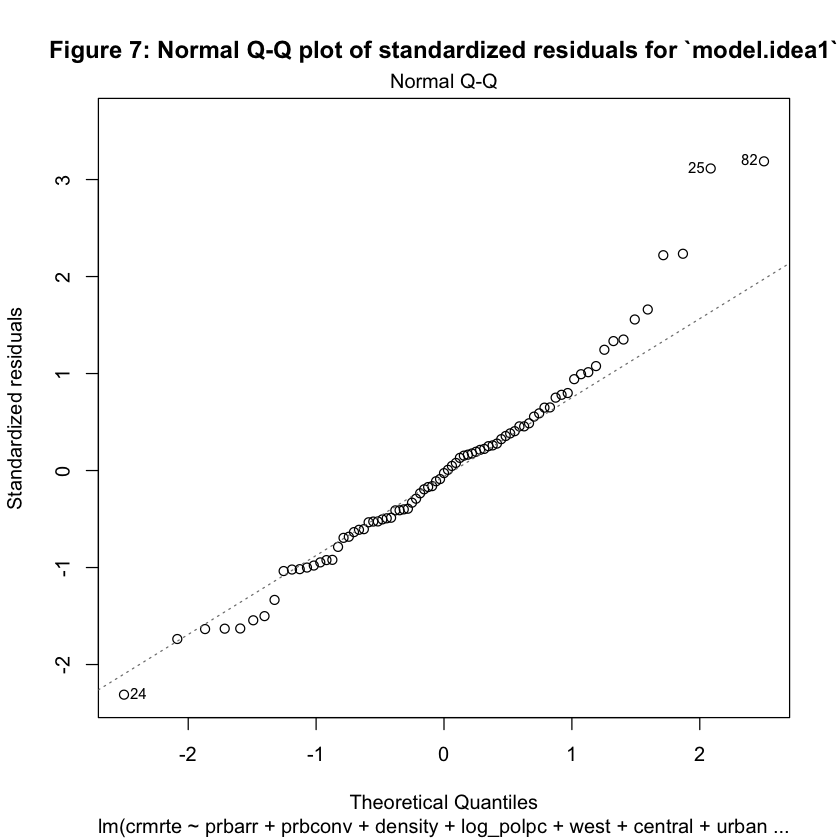

In [17]:
shapiro.test(model.idea1$residuals) # H_0: distribution is normal
plot(model.idea1, which=2, main="Figure 7: Normal Q-Q plot of standardized residuals for `model.idea1`")

# Regression results


## Results for `model.idea1`, our preferred model

The key coefficient of -0.059 for `prbarr` suggests that increasing the probability of arrest by 10 percentage points would be associated with about 5.9 fewer crimes per 1,000 people, holding other factors constant. It is statistically significant at a 0.1% significance level. The effect size is moderate, given that the average crime rate is about 35 per 1,000 people. This variable also has the largest negative impact on `crmrte` overall.

The adjusted $R^2$ is 0.82, indicating that this model would explain 82% variation of crime rate, which is only one percentage point lower than using `model.maximal` and including five additional covariates. Among the control variables, `density` is also statistically significant at a 0.1% significance level. Additionally, `log_polpc` is statistically significant at a 1% significance level. The `central` dummy, as well as two of the three wage variables (`log_wser` and `log_wcon`) are each significant at a 5% significance level.

In [18]:
stargazer(model.minimal, model.idea1, model.idea2, model.maximal, type = "text", omit.stat = "f",
          se = list(se.model.minimal, se.model.idea1, se.model.idea2, se.model.maximal),
          star.cutoffs = c(0.05, 0.01, 0.001), 
          title="Table 3: Regression results for all models discussed")


Table 3: Regression results for all models discussed
                                          Dependent variable:                      
                    ---------------------------------------------------------------
                                                crmrte                             
                          (1)             (2)             (3)             (4)      
-----------------------------------------------------------------------------------
prbarr                 -0.046***       -0.059***       -0.061***       -0.057***   
                        (0.014)         (0.014)         (0.013)         (0.013)    
                                                                                   
prbconv                                 -0.011                          -0.008     
                                        (0.007)                         (0.009)    
                                                                                   
density               

The three log wage variables are jointly significant at a 5% significance level, given that an F-test returned a p-value of 0.029.

In [19]:
# F-test: joint significance of three wages
print("Table 4: F-test results for joint significance of wages")
linearHypothesis(model.idea1, c("log_wser=0", "log_wtrd=0", "log_wcon=0"), vcov=vcovHC)

[1] "Table 4: F-test results for joint significance of wages"


Res.Df,Df,F,Pr(>F)
71,NA,NA,NA
68,3,3.193949,0.02890859


The three geographic dummy variables are not jointly significant at a 5% significance level. An F-test returned a p-value of 0.099:

In [20]:
# F-test: joint significance of west, central, and urban
print("Table 5: F-test results for joint significance of west, urban, and central")
linearHypothesis(model.idea1, c("west=0","urban=0","central=0"),vcov = vcovHC,)

[1] "Table 5: F-test results for joint significance of west, urban, and central"


Res.Df,Df,F,Pr(>F)
71,NA,NA,NA
68,3,2.172702,0.09921062


In [21]:
coeftest(model.idea1, vcov=vcovHC)


t test of coefficients:

              Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  0.0971529  0.0771915  1.2586  0.212480    
prbarr      -0.0587818  0.0140434 -4.1857 8.353e-05 ***
prbconv     -0.0111214  0.0074452 -1.4938  0.139862    
density      0.0057017  0.0012513  4.5566 2.221e-05 ***
log_polpc    0.0217452  0.0080947  2.6864  0.009071 ** 
west        -0.0066015  0.0056333 -1.1719  0.245335    
central     -0.0084485  0.0037992 -2.2237  0.029492 *  
urban       -0.0029736  0.0062290 -0.4774  0.634623    
pctmin80     0.0239307  0.0134208  1.7831  0.079032 .  
pctymle      0.0652493  0.0463042  1.4091  0.163349    
log_wser    -0.0172673  0.0086978 -1.9852  0.051153 .  
log_wtrd     0.0149334  0.0132678  1.1255  0.264319    
log_wcon     0.0180418  0.0090190  2.0004  0.049450 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


We also see that `model.idea2` and `model.maximal` have similar magnitudes of the key coefficient, `prbarr`, with `model.idea1`, suggesting that our results are quite robust.

# Omitted variables

We think the following variables are potential omitted variables in identifying the relationship between the crime rate and probability of arrest:

1. Share of religious residents
2. Distance to large manufacturing site
3. GDP per capita
4. Property tax per capita
5. Dummy variable of whether the county has good school district:
6. Minimum wage
7. Share of single mothers
8. Average net asset
9. Highschool dropout rate
10. Unemployment rate

In order to decide the direction of omitted variable bias (OVB) resulting from each of the variables, we analyze two pairs of correlations. First, we examine the correlations between the omitted variable and the crime rate (denoted as $\beta$); second, we examine the correlation between the omitted variable and probability of arrest (denoted as $\delta$). As we assume the true relationship between the crime rate and probability of arrest is negative, so a positive OVB is towards zero, and a negative OVB is away from zero.

## Share of religious residents:
- Towards zero; positive OVB ($\beta$ < 0, and $\delta$ < 0)
- Explanation: More religious residents should commit fewer crimes, and they are perceived as upstanding citizens so their probability of arrest should be lower.

## Distance to large manufacturing site:
- Towards zero; positive OVB ($\beta$ < 0, and $\delta$ < 0)
- Explanation: A smaller distance indicates more job availability, and people with more job opportunities are less likely to conduct crimes. People with stable jobs should have lower probability of arrest.

## GDP per capita:
- Towards zero; positive OVB ($\beta$ < 0, and $\delta$ < 0)
- Explanation: Residents with good income have less incentive to commit a crime. And richer people are less likely to get arrested when there is an offense.

## Property tax per capita:
- Away from zero; negative OVB ($\beta$ < 0, and $\delta$ > 0)
- Available Proxy variable: `taxpc`, or tax per capita is obviously similar to property tax per capita but the property tax differentiates itself since it's only generated from the value of the real-estate in the area.
- Explanation: Property tax per capita measures how good/safe the community is. Better communities typically have lower crime rates. The probability of arrest could be higher in nicer neighborhoods since the police would be well funded and incentivised to protect the high revenue-generating neighborhoods.

## Dummy variable of whether the county has good school district:
- Towards zero; positive OVB ($\beta$ < 0, and $\delta$ < 0)
- Explanation: People with better education should commit fewer crimes. And better educated people are less likely to be arrested.

## Minimum wage:
- Towards zero; positive OVB ($\beta$ < 0, and $\delta$ < 0)
- Available Proxy variables: log_wtrd, log_wser, and log_wcon. These wages (retail, service, and construction respectively) act as a proxy for the minimum wage as the wages for these jobs/sectors tend to hover above the minimum wage.
- Explanation: If a county has a higher minimum wage, the lives of low-income workers are better supported and they are less likely to commit crime. People with higher income are less likely to get arrested when there is an offense.

## Share of single mothers:
- Towards zero; positive OVB ($\beta$ > 0, and $\delta$ > 0)
- Explanation: Less resources and time to help watch children might lead to increased crime. In addition, if the children’s father is in prison, this may potentially lead to a young male thinking that’s what they’re destined for. Kids with lower socioeconomic status may be more likely to be arrested when there is an offense.

## Average net asset:
- Towards zero; positive OVB ($\beta$ < 0, and $\delta$ < 0)
- Explanation: Residents with more assets have less incentive to commit a crime. And wealthier people are less likely to get arrested when there is an offense.

## High school dropout rate:
- Towards zero; positive OVB ($\beta$ > 0, and $\delta$ > 0)
- Explanation: Increased rates of highschool dropouts would lead to more under-educated, unemployed youth with too much free time on their hands which in turn could result in increased crime-rate. Counties with high rates of highschool dropouts would likely have policies leading to an increased probability of arrest.

## Unemployment rate:
- Towards zero; positive OVB ($\beta$ > 0, and $\delta$ > 0)
- Explanation Increased unemployment would lead to increased economic instability which could cause individuals to commit more crimes to make ends meet. Areas with increased unemployment would likely have an increased probability of arrest.

We are not able to quantify the sizes of these omitted variable bias, but we think the ones with the largest effects would be: the unemployment rates, share of single mothers, and property tax per capita. 
We found that most of the omitted variables we considered resulted in a “towards zero” bias except for property tax per capita. The omitted variable bias from property tax per capita would cause the model parameter estimate for probability of arrest to have a larger effect than we would expect if we could include property tax per capita in our analysis. Otherwise, our model would not exaggerate the relationship we found between crime rate and probability of arrest.


# Conclusion

## Policy recommendations

Our model suggests that making it more likely to get punishment is associated with reducing crimes: increasing the probability of arrest by ten percentage points is associated with about six fewer crimes per 1,000 people, holding other factors constant. The effect is statistically significant, but the practical effect is moderate. Based on this result, we came up with a few policy recommendations for the political campaign.

Based on `model.idea1`, several policy recommendations fall out of our analysis. There are four categories the variables in this model fall into; location (density, west, central, urban), economic determinants (wages in the service, retail and construction sectors), demographic makeup (percent young male and percent minority), and policing policy (probability of arrest/conviction and police per capita). 

Location and demographic makeup variables help us understand the at risk population and where we should focus additional resources to help prevent crime. For example if there is a high percentage of young males in a given county it might be prudent to invest in free afterschool programs to keep the young males busy with prosocial behavior which could help reduce crime. 

The economic determinants help us understand the average wage of the lower-income sectors of the economy. If we observe a county with a high crime rate and low wages we could recommend piloting a local jobs training and small business stimulus package to engage the local economy by providing jobs and increasing wages.

Policing policy is a contentious topic that is paramount in decreasing crime. The variables in this category are probability of arrest, probability of conviction and police per capita; the parameter estimates for these variables are negative, negative and positive respectively. By following the signs of the parameter estimates to decrease crime we would want to increase the probability of arrest, increase the probability of conviction, and decrease the police per capita. These recommendations don’t necessarily make sense alone but with some consideration one can come to sensible policy recommendations from this model. Increasing the probability of arrest and probability of conviction are achieved by increasing the ratio of arrests to offenses and increasing the ratio of convictions to arrests. It is not enough to simply arrest more people and have judges that convict more people, a strategic approach is required. The strategic approach we recommend would focus on police training, resulting in a police force that is arresting people who would be convicted of crimes. As for decreasing the police per capita to reduce the crime rate, as we mentioned earlier in the report this may result from reverse causality. Counties with high crime rates might need to hire more police to help decrease the crime rate. 

A holistic approach to decreasing crime would touch on all four categories mentioned above. Targeting the locations and demographics that need the most help, providing economic opportunities, and focusing on improving the training of police. 


## Closing remarks

Although we were able to come up with several policy recommendations to provide to the political campaign, we acknowledge that the data used for this study was limiting in that it only gave us an idea of what North Carolina looked like at a specific time. In the future, we hope to perform this sort of analysis on time series data to understand how crime changed in North Carolina over the years. In addition, we hope to use data from ALL counties in North Carolina (six counties had no data for us to use and ten had corrupt data), or expand the research to other states, choosing randomly to ensure random sampling. 

Overall, we hope our findings will aid the political campaign by providing policies that help reduce the crime rate. We will only be able to see if these policies make a difference if we monitor the crime before and after the policy is in place. 

# Appendix

**Figure i.1:** Histograms of all raw variables, before applying any log transformations.

No id variables; using all as measure variables
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


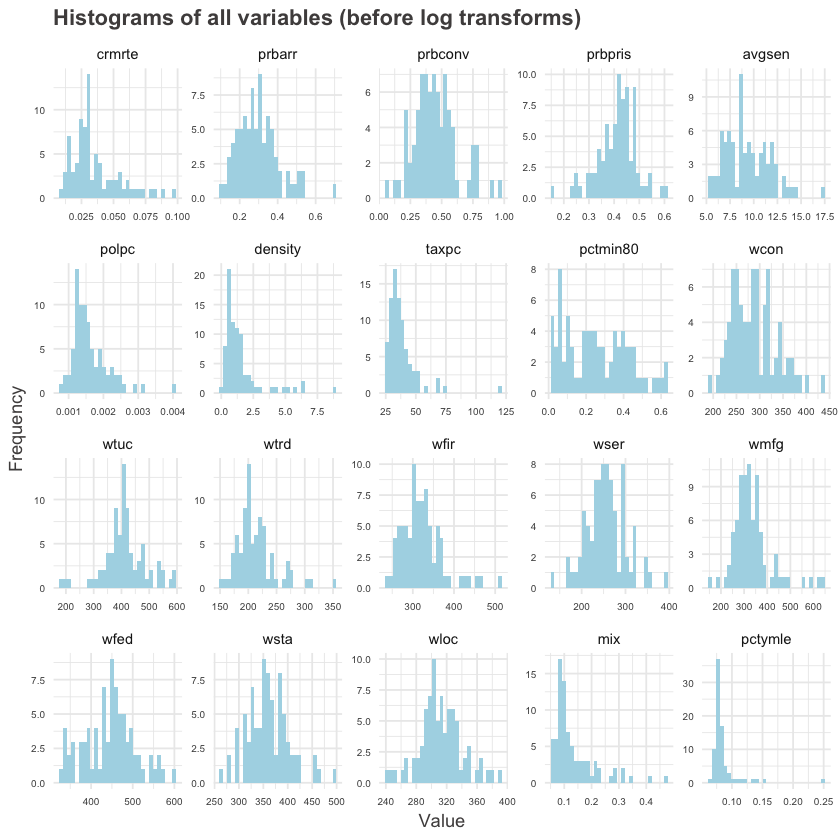

In [22]:
# Before logarithmic transformations
numeric_hist <- crime_v2 %>% select(-c(county, year, west, central, urban))
numeric_hist <- numeric_hist[, !colnames(numeric_hist) %in% log_cols]
numeric_hist <- melt(numeric_hist)
ggplot(numeric_hist, aes(x=value)) + geom_histogram(fill='lightblue') + 
    facet_wrap(~variable, scales="free") + ggtitle('Histograms of all variables (before log transforms)') + 
    xlab('Value') + ylab('Frequency') + theme_minimal() +
    theme(text=element_text(color="#4f4c4c"),
          plot.title=element_text(face="bold"),
          axis.text=element_text(size=6))

**Figure i.2:** Scatter plot matrix of all other variables (correlations between 0.25 and 0.4)

Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
“could not fit smooth”Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
“could not fit smooth”Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
“could not fit smooth”Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
“could not fit smooth”Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
“could not fit smooth”Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
“could not fit smooth”Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
“could not fit smooth”

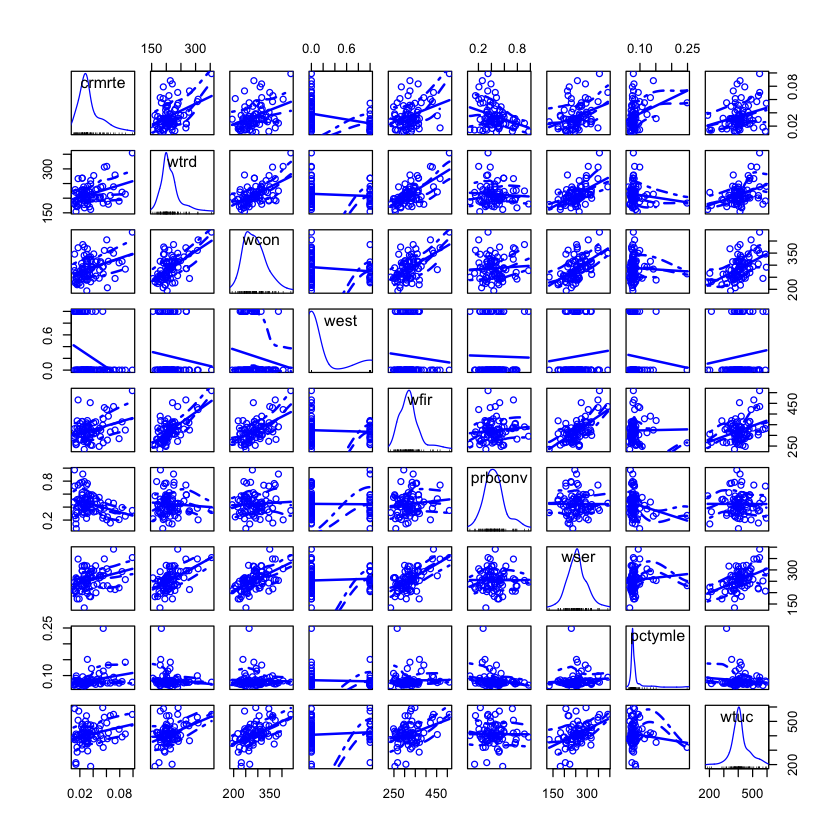

In [23]:
scatterplotMatrix(crime_v2[, c('crmrte', 'wtrd', 'wcon', 'west', 'wfir', 'prbconv',
                               'wser', 'pctymle', 'wtuc')])

**Figure i.3:** Scatter plot matrix of all other variables (correlations less than 0.25)

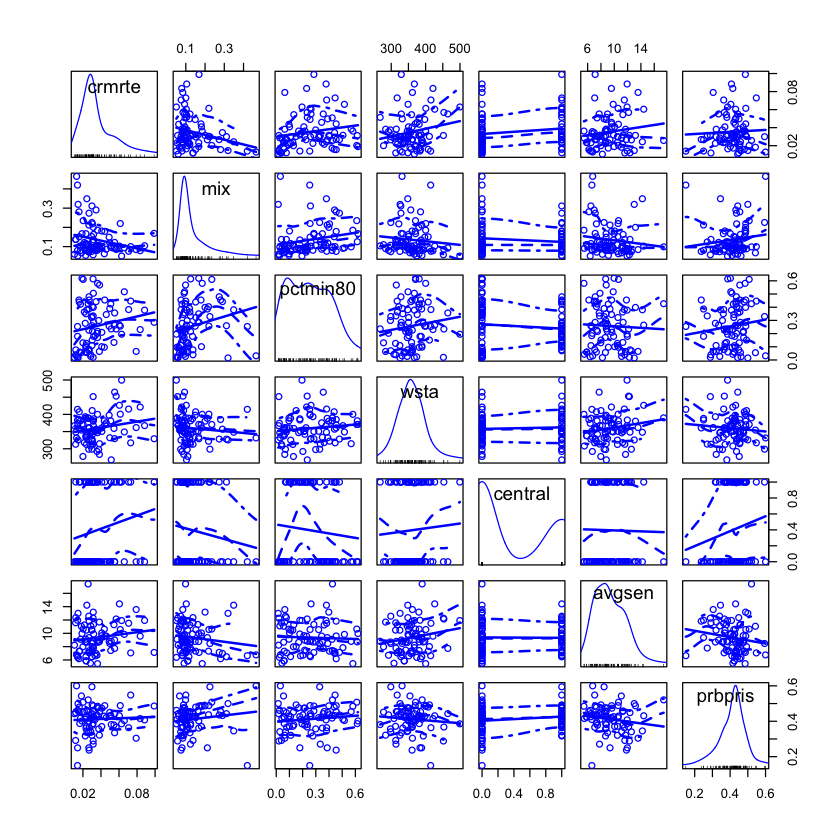

In [24]:
scatterplotMatrix(crime_v2[, c('crmrte', 'mix', 'pctmin80', 'wsta', 'central', 'avgsen', 'prbpris')])

**Figure i.4:** Histogram of model residuals

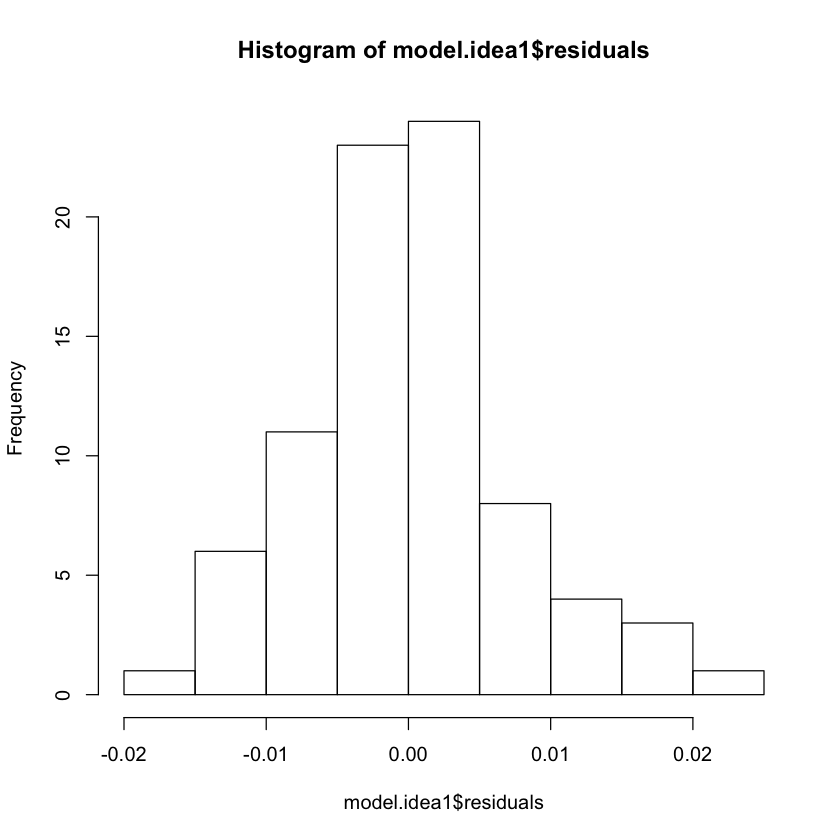

In [25]:
hist(model.idea1$residuals)

# References

[1] Wooldridge, Jeffrey M., 1960-. Introductory Econometrics : a Modern Approach. Mason, Ohio :South-Western Cengage Learning, 2012.